# analysis of altimetric data

In [4]:
import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt

import gcsfs.mapping

#from h3 import h3
import pyinterp

In [1]:
import dask

In [12]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=10)

In [13]:
cluster

Task exception was never retrieved
future: <Task finished coro=<_wrap_awaitable() done, defined at /srv/conda/envs/notebook/lib/python3.7/asyncio/tasks.py:596> exception=AssertionError()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/asyncio/tasks.py", line 603, in _wrap_awaitable
    return (yield from awaitable.__await__())
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/deploy/spec.py", line 42, in _
    assert self.status == "running"
AssertionError
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f912ba8acc0>>, <Task finished coro=<SpecCluster._correct_state_internal() done, defined at /srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/deploy/spec.py:284> exception=AssertionError()>)
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/tornado/ioloop.py"

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:41499 Dashboard: /user/apatlpo-itide_ops-xb9myq4p/proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [5]:
fs = gcsfs.GCSFileSystem(project='pangeo-cnes', token=None)
gcsmap = gcsfs.mapping.GCSMap('pangeo-cnes/alti/tp', gcs=fs)

In [6]:
ds = xr.open_zarr(gcsmap, consolidated=True)
print('Dataset size = %.1f GB' %(ds.nbytes/1e9))
ds

Dataset size = 8.8 GB


<xarray.Dataset>
Dimensions:         (time: 157384325)
Coordinates:
    latitude        (time) float64 dask.array<chunksize=(1000000,), meta=np.ndarray>
    longitude       (time) float64 dask.array<chunksize=(1000000,), meta=np.ndarray>
  * time            (time) datetime64[ns] 1992-12-31T23:20:35.775270144 ... 2002-04-24T07:56:09.359487744
Data variables:
    cycle           (time) int16 dask.array<chunksize=(1000000,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(1000000,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(1000000,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(1000000,), meta=np.ndarray>
    ocean_tide      (time) float64 dask.array<chunksize=(1000000,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(1000000,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(1000000,), meta=np.ndarray>
    track           (time) int16 dask.array<chu

---

## xhistogram 

---
## pyinterp approach

[pyinterp doc](https://pangeo-pyinterp.readthedocs.io/en/latest/examples.html)

In [8]:
ds0 = ds

In [9]:
ds = ds0.isel(time=slice(0,int(1e8))).chunk({'time':1e6})
#ds = ds0.where((ds.longitude<45)&(ds.longitude>-45), drop=True)
#ds = ds0 # crashes
print('Dataset size = %.1f GB' %(ds.nbytes/1e9))

Dataset size = 5.6 GB


In [10]:
ds = ds.persist()

In [15]:
binning = pyinterp.Binning2D(
    pyinterp.Axis(np.arange(-180, 180, 1), is_circle=True),
    pyinterp.Axis(np.arange(-90, 95, 1)))

In [ ]:
#mx, my = np.meshgrid(ds.longitude, ds.latitude)
binning.push(ds.longitude, ds.latitude, ds.mdt, simple=True)

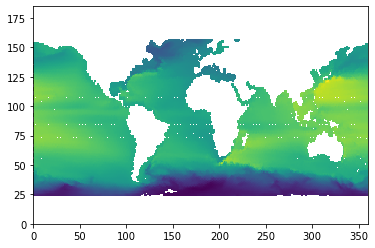

In [13]:
plt.pcolormesh(binning.variable('mean').T)

In [ ]:
binning.variable('mean')

In [8]:
np.asarray(ds.mdt).flatten().shape

(10000,)

---
## h3

In [ ]:
ds = ds.isel(time=slice(0,int(1e6)))
print('Dataset size = %.1f GB' %(ds.nbytes/1e9))

df = ds.to_dataframe()
df

In [ ]:
resolution = 7
%time df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["latitude"], row["longitude"], resolution), axis = 1)

In [ ]:
df

In [ ]:
df_stats = df.groupby('hex_id').mean()